# Train student GAN

In [2]:
import torch_utils_rich_mrartemev as utils_rich
import wandb
import torch
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from catboost import CatBoostClassifier, Pool

from torch import nn
from IPython.display import clear_output
from tqdm import tqdm_notebook, tqdm
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader

from data import *


%matplotlib inline

## Configurations

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

PARTICLE_TYPE = 'pion'

BATCH_SIZE = 20000
BATCH_SIZE_VAL = 8192
LATENT_DIMENSIONS = 64
NOISE_SIZE = 64
CRAMER_DIM = 512
TEACHER_LAYERS = 10
STUDENT_LAYERS = 2

CRITIC_ITERATIONS_CONST = 10
TOTAL_ITERATIONS = int(6e4) // 245
VALIDATION_INTERVAL = 1000

device = 'cuda' if torch.cuda.is_available() else 'cpu'
weight_cliping_limit = 0.015

## Data

In [ ]:
data_train, data_val, scaler = utils_rich.get_merged_typed_dataset(PARTICLE_TYPE, dtype=np.float32, log=True)

Reading and concatenating datasets:
	../data/data_calibsample/pion2_-_down_2016_.csv
	../data/data_calibsample/pion_+_down_2016_.csv
	../data/data_calibsample/pion_-_up_2016_.csv
	../data/data_calibsample/pion_-_down_2016_.csv
	../data/data_calibsample/pion2_+_down_2016_.csv
	../data/data_calibsample/pion2_-_up_2016_.csv
	../data/data_calibsample/pion_+_up_2016_.csv
	../data/data_calibsample/pion2_+_up_2016_.csv


In [ ]:
data_train.head()

In [ ]:
from itertools import repeat

class ParticleSet(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, ind):
        return (self.data[ind, utils_rich.y_count:-1], # X
                self.data[ind, -1], # Weight
                self.data[ind, :utils_rich.y_count], # DLL
               )
    
train_loader = torch.utils.data.DataLoader(ParticleSet(data_train.values),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    pin_memory=True)

val_loader = torch.utils.data.DataLoader(ParticleSet(data_val.values),
                                                  batch_size=BATCH_SIZE_VAL,
                                                  shuffle=False,
                                                  pin_memory=True)

## Model

In [ ]:
def get_noise(batch_size, mean=0, std=1):
    return torch.zeros(batch_size, LATENT_DIMENSIONS).normal_(mean, std).to(device)

class Generator(nn.Module):
    def __init__(self, hidden_size=128, depth=5):
        super(Generator, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(LATENT_DIMENSIONS + data_train.shape[1] - 1 - utils_rich.y_count, hidden_size),
            nn.LeakyReLU(),
            *[nn.Sequential(
                nn.utils.weight_norm(nn.Linear(hidden_size, hidden_size)),
                nn.LeakyReLU()) for _ in range(depth)
             ],
            nn.Linear(hidden_size, utils_rich.y_count),
        )

    def forward(self, x, noise=None):
        return self.layers(torch.cat([x, get_noise(x.shape[0])], dim=1))

    
class Critic(nn.Module):
    def __init__(self, hidden_size=128, depth=5):
        super(Critic, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(data_train.shape[1] - 1, hidden_size),
            nn.LeakyReLU(),
            *[nn.Sequential(nn.Linear(hidden_size, hidden_size), nn.LeakyReLU()) for _ in range(depth)],
            nn.Linear(hidden_size, 1),
        )

    def forward(self, x):
        return self.layers(x)
    
    def get_after_n(self, x, n):
        for idx, (name, layer) in enumerate(self._modules.items()):
            x = layer(x)
            if idx == n:
                break
        return x

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [ ]:
G = Generator(depth=TEACHER_LAYERS).to(device)
G.apply(init_weights)

C = Critic(depth=TEACHER_LAYERS).to(device)
C.apply(init_weights)

G_student = Generator(depth=STUDENT_LAYERS).to(device)
G_student.apply(init_weights)

C_student = Critic(depth=STUDENT_LAYERS).to(device)
C_student.apply(init_weights);

In [ ]:
optimizerC = torch.optim.RMSprop(C_student.parameters(), lr=0.00005) 
optimizerG = torch.optim.RMSprop(G_student.parameters(), lr=0.00005) 

C.load_state_dict(torch.load('C_teacher_10_u.pth'))
G.load_state_dict(torch.load('G_teacher_10_u.pth'))

C.to(device)
G.to(device)

C_student.to(device)
G_student.to(device);

In [ ]:
C_student.load_state_dict(torch.load('C_distillation_10_l1.pth'))
G_student.load_state_dict(torch.load('G_distillation_10_l1.pth'))

## Train

In [9]:
os.environ["WANDB_API_KEY"] = "f59a698ea7b8d90b5e714412120fe93da03c5234"

In [10]:
# Weights & Biases
wandb.init(project="rich-gan-distilling")

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Currently logged in as: apshirokov (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.18 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [11]:
def plot(log=False):
    dlls = None
    student_generated = None
    teacher_generated = None
    weights = None
    xx = None

    with torch.no_grad():
        for x, weight, real in val_loader:
            weight = weight.detach().cpu().numpy()
            dll = real.detach().cpu().numpy()[:,:utils_rich.y_count]
            x = x.to(device)
            teacher_gen = G(x).detach().cpu().numpy()
            student_gen = G_student(x).detach().cpu().numpy()
            x = x.detach().cpu().numpy()

            if xx is None:
                xx = x
            else:
                xx = np.concatenate((xx, x))

            if dlls is None:
                dlls = dll
            else:
                dlls = np.concatenate((dlls, dll))

            if weights is None:
                weights = weight
            else:
                weights = np.concatenate((weights, weight))

            if teacher_generated is None:
                teacher_generated = teacher_gen
            else:
                teacher_generated = np.concatenate((teacher_generated, teacher_gen))

            if student_generated is None:
                student_generated = student_gen
            else:
                student_generated = np.concatenate((student_generated, student_gen))

        fig, axes = plt.subplots(3, 2, figsize=(15, 15))
        for particle_type, ax in zip((0, 1, 2, 3, 4), axes.flatten()):
            sns.distplot(dlls[:, particle_type], hist_kws={'weights': weights, 'alpha': 1}, kde=False, bins=100, ax=ax, label="real", norm_hist=True)
            sns.distplot(student_generated[:, particle_type], hist_kws={'weights': weights, 'alpha': 0.5}, kde=False, bins=100, ax=ax, label="student", norm_hist=True)
            sns.distplot(teacher_generated[:, particle_type], hist_kws={'weights': weights, 'alpha': 0.5}, kde=False, bins=100, ax=ax, label="teacher", norm_hist=True)
            ax.legend()
            ax.set_title(utils_rich.dll_columns[particle_type])
        
        if log:
            wandb.log({"hist/normalized": wandb.Image(plt)})
            plt.clf()
        else:
            plt.show()

In [12]:
# The coefficients needed for losses
alpha = 10
l_4coef = 0
l_5coef = 0
l_7coef = 0
l_8coef = 0

In [ ]:
iteration = 0

for _ in tqdm(range(TOTAL_ITERATIONS*10), position=0, leave=True):
    for x, weight, dll in train_loader:
        iteration += 1
        
        x = x.to(device)
        weight = weight.to(device)
        dll = dll.to(device)
        real_row = torch.cat([dll, x], dim=1)
        
        if (iteration + 1) % 5:
            # Train Discriminator...
            C_student.zero_grad()
            
            # Clamp parameters to a range [-c, c], c=self.weight_cliping_limit
            for p in C_student.parameters():
                p.data.clamp_(-weight_cliping_limit, weight_cliping_limit)
            
            # with real dll
            real_loss = C_student(real_row)
            # with fake dll
            fake_dll = G_student(x).detach()
            fake_row = torch.cat([x, fake_dll], dim=1)
            fake_loss = C_student(fake_row)
            
            # total discriminator loss
            discriminator_loss = fake_loss.mean() - real_loss.mean()# + gradient_penalty*10
            discriminator_loss.backward()
            wandb.log({"Critic loss": discriminator_loss.item()})
        
            teacher_dll = G(x).detach()
            teacher_row = torch.cat([x, teacher_dll], dim=1)
            # Calculate L_Gt  (Fcn. 7 from paper) 
            output_gt = -l_7coef*C_student(teacher_row).mean()
            output_gt.backward()
            wandb.log({"L_Gt": output_gt.item()})
            
            # Calculate L_tri (Fcn. 8 from paper)
            output_tri = torch.norm(C_student.get_after_n(real_row, 4) - C_student.get_after_n(teacher_row, 4), dim=0) - \
                         torch.norm(C_student.get_after_n(real_row, 4) - C_student.get_after_n(fake_row, 4), dim=0) + alpha
            output_tri = l_8coef * torch.clamp(output_tri, min=0).mean()
            output_tri.backward()
    
            optimizerC.step()
        else:   
            # Train Generator
            optimizerG.zero_grad()
            fake_dll = G_student(x)
            fake_row = torch.cat([x, fake_dll], dim=1)
            teacher_dll = G(x)
            teacher_row = torch.cat([x, teacher_dll], dim=1)
            generator_loss = -C_student(fake_row).mean()
            generator_loss.backward()
            
            # Calculate L1_loss (Fcn. 4 from paper)
            l1 = l_4coef*torch.abs(G(x) - G_student(x)).mean()
            l1.backward()
            
            # Calculate L_perc  (Fcn. 5 from paper)
            fake_dll = G_student(x)
            fake_row = torch.cat([x, fake_dll], dim=1)
            teacher_dll = G(x)
            teacher_row = torch.cat([x, teacher_dll], dim=1)
            l_perc = (l_5coef * (torch.norm(C.get_after_n(teacher_row, 10) - C.get_after_n(fake_row, 10), dim=0).pow(2))).mean()
            l_perc.backward()
    
            wandb.log({"L1_loss": l1.mean().item()})
            wandb.log({"L_perc": l_perc.mean().item()})

            optimizerG.step()
            
    # Save weights
    if iteration % 100 == 0:
        torch.save(C_student.state_dict(), 'C_distillation_10_u.pth')
        torch.save(G_student.state_dict(), 'G_distillation_10_u.pth')
        plot(log=True)

  0%|          | 0/2440 [00:00<?, ?it/s]/home/mrartemev/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
  0%|          | 4/2440 [03:55<39:55:16, 59.00s/it]

## Test

In [ ]:
dlls = None
student_generated = None
teacher_generated = None
weights = None
xx = None

with torch.no_grad():
    for x, weight, real in val_loader:
        weight = weight.detach().cpu().numpy()
        dll = real.detach().cpu().numpy()[:,:utils_rich.y_count]
        x = x.to(device)
        teacher_gen = G(x).detach().cpu().numpy()
        student_gen = G_student(x).detach().cpu().numpy()
        x = x.detach().cpu().numpy()
        
        if xx is None:
            xx = x
        else:
            xx = np.concatenate((xx, x))

        if dlls is None:
            dlls = dll
        else:
            dlls = np.concatenate((dlls, dll))

        if weights is None:
            weights = weight
        else:
            weights = np.concatenate((weights, weight))

        if teacher_generated is None:
            teacher_generated = teacher_gen
        else:
            teacher_generated = np.concatenate((teacher_generated, teacher_gen))
            
        if student_generated is None:
            student_generated = student_gen
        else:
            student_generated = np.concatenate((student_generated, student_gen))

    fig, axes = plt.subplots(3, 2, figsize=(15, 15))
    for particle_type, ax in zip((0, 1, 2, 3, 4), axes.flatten()):
        sns.distplot(dlls[:, particle_type], hist_kws={'weights': weights, 'alpha': 1}, kde=False, bins=100, ax=ax, label="real", norm_hist=True)
        sns.distplot(student_generated[:, particle_type], hist_kws={'weights': weights, 'alpha': 0.5}, kde=False, bins=100, ax=ax, label="student", norm_hist=True)
        sns.distplot(teacher_generated[:, particle_type], hist_kws={'weights': weights, 'alpha': 0.5}, kde=False, bins=100, ax=ax, label="teacher", norm_hist=True)
        ax.legend()
        ax.set_title(utils_rich.dll_columns[particle_type])

    plt.show()

Exception: The wandb backend process has shutdown

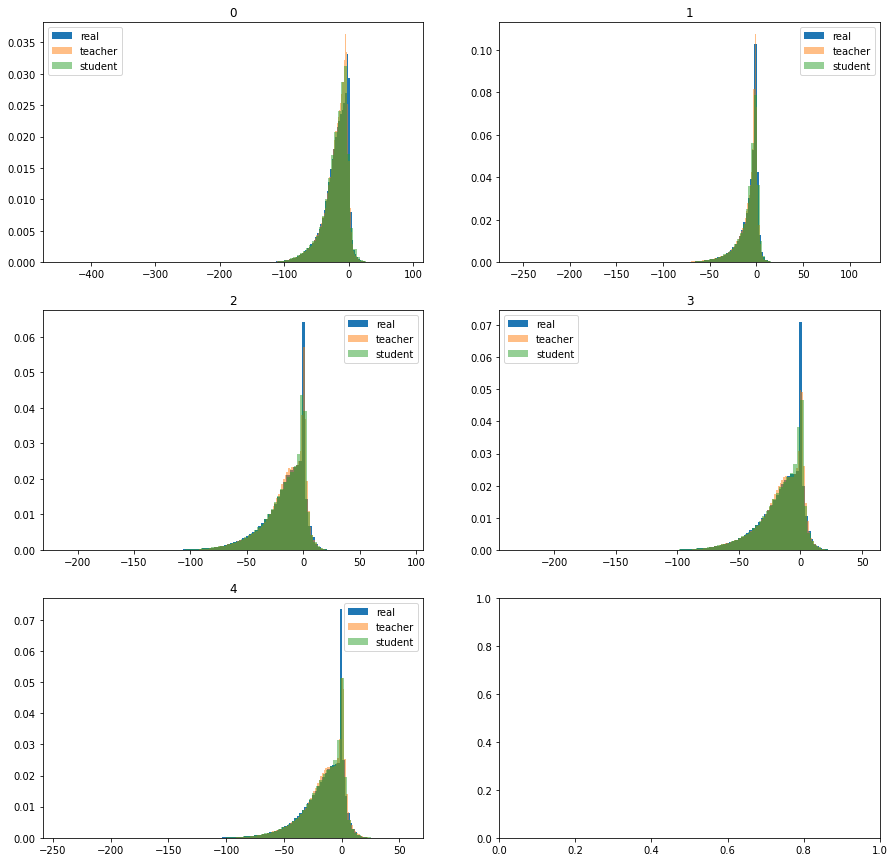

In [22]:
dlls_inversed = inversescale(dlls)
teacher_generated_inversed = inversescale(teacher_generated)
student_generated_inversed = inversescale(student_generated)


fig, axes = plt.subplots(3, 2, figsize=(15, 15))
for particle_type, ax in zip((0, 1, 2, 3, 4), axes.flatten()):
    sns.distplot(dlls_inversed[:, particle_type], hist_kws={'alpha': 1}, kde=False, bins=100, ax=ax, label="real", norm_hist=True)
    sns.distplot(teacher_generated_inversed[:, particle_type], hist_kws={'alpha': 0.5}, kde=False, bins=100, ax=ax, label="teacher", norm_hist=True)
    sns.distplot(student_generated_inversed[:, particle_type], hist_kws={'alpha': 0.5}, kde=False, bins=100, ax=ax, label="student", norm_hist=True)
    ax.legend()
    ax.set_title(particle_type)

plt.show()

In [24]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

y = [1] * dlls_inversed.shape[0]
y.extend(list([0] * student_generated_inversed.shape[0]))
X = np.concatenate((dlls_inversed, student_generated_inversed))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)

classifier = CatBoostClassifier(iterations=1000,
                custom_metric=['Logloss', 'AUC'],
                task_type="GPU",
                devices='0:1')

classifier.fit(X_train,
                y_train,
                verbose=False,
                plot=False);

predicted = classifier.predict(X_test)

from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted, pos_label=1)
metrics.auc(fpr, tpr)

0.717739156886109